# Class hierarchy

In [58]:
from collections import defaultdict

class ClassHierarchy:
    def __init__(self, hierarchy_path, id_to_name_path):
        self.id_to_name_map = {}
        self.name_to_id_map = defaultdict(list)
        self.parent_child_map = defaultdict(list)
        self.child_parent_map = defaultdict(list)

        with open(id_to_name_path, encoding="utf-8") as f:
            for line in f:
                line = line.strip()
                id, name = line.rsplit('\t')
                self.id_to_name_map[id] = name
                self.name_to_id_map[name].append(id)

        with open(hierarchy_path, encoding='utf-8', mode='r') as f:
            for line in f:
                line = line.strip()
                parent, child = line.split(' ')
                self.parent_child_map[parent].append(child)
                self.child_parent_map[child].append(parent)

    def convert_id_to_name(self, id):
        return self.id_to_name_map.get(id, None)

    def convert_ids_to_names(self, ids):
        return [self.id_to_name_map.get(id, None) for id in ids]

    def convert_name_to_ids(self, name):
        # Return a shallow copied version
        return self.name_to_id_map[name][:]

    def convert_names_to_ids(self, names):
        return [self.convert_name_to_ids(name) for name in names]

    def find_parents(self, class_id):
        # Return a shallow copied version
        return self.child_parent_map[class_id][:]

    def find_siblings(self, class_id):
        parent_ids = self.find_parents(class_id)
        sibling_ids = set()
        for parent_id in parent_ids:
            for sibling_id in self.parent_child_map[parent_id]:
                sibling_ids.add(sibling_id)

        if class_id in sibling_ids:
            sibling_ids.remove(class_id)
        return sibling_ids

    def find_ancestors(self, class_id):
        q = self.find_parents(class_id)
        ancestor_ids = set()
        while q:
            ancestor_id = q.pop()
            q.extend(self.child_parent_map[ancestor_id])
            ancestor_ids.add(ancestor_id)

        return ancestor_ids

    def check_common_ancestor(self, class_id1, class_id2):
        first_ancestors = self.find_ancestors(class_id1)
        second_ancestors = self.find_ancestors(class_id2)
        common_ancestors = first_ancestors.intersection(second_ancestors)
        return len(common_ancestors) > 0

In [59]:
# Initialize class hierarchy
class_hierarchy = ClassHierarchy('hierarchy.txt', 'id_to_name.txt')

# Task 1

- Find all siblings class of a class name
- Find the parent class of a class name
- Find all ancestor classes of a class name
- Find if both class 1 and class 2 belong to the same ancestor class(es)


In [38]:
# Find parents
class_name = 'apple'
class_ids = class_hierarchy.convert_name_to_ids(class_name)

if class_ids:
    # Pick the only first class id
    class_id = class_ids[0]
    parent_ids = class_hierarchy.find_parents(class_id)
    parent_names = class_hierarchy.convert_ids_to_names(parent_ids)
    print(parent_names)

['edible fruit', 'pome, false fruit']


In [42]:
# Find siblings
class_name = 'apple'
class_ids = class_hierarchy.convert_name_to_ids(class_name)

if class_ids:
    # Pick the only first class id
    class_id = class_ids[0]
    sibling_ids = class_hierarchy.find_siblings(class_id)
    sibling_names = class_hierarchy.convert_ids_to_names(sibling_ids)
    print(sibling_names)

[]


In [61]:
# Find all ancestor classes of a class name
class_name = 'apple'
class_ids = class_hierarchy.convert_name_to_ids(class_name)

if class_ids:
    # Pick the only first class id
    class_id = class_ids[0]
    ancestor_ids = class_hierarchy.find_ancestors(class_id)
    ancestor_names = class_hierarchy.convert_ids_to_names(ancestor_ids)
    print(ancestor_names)

['reproductive structure', 'food, solid food', 'matter', 'physical entity', 'natural object', 'solid', 'pome, false fruit', 'edible fruit', 'plant part, plant structure', 'entity', 'whole, unit', 'object, physical object', 'plant organ', 'fruit', 'produce, green goods, green groceries, garden truck']


In [62]:
# Find all ancestor classes of a class name
class_name = 'orange'
class_ids = class_hierarchy.convert_name_to_ids(class_name)

if class_ids:
    # Pick the only first class id
    class_id = class_ids[0]
    ancestor_ids = class_hierarchy.find_ancestors(class_id)
    ancestor_names = class_hierarchy.convert_ids_to_names(ancestor_ids)
    print(ancestor_names)

['reproductive structure', 'food, solid food', 'matter', 'physical entity', 'natural object', 'solid', 'edible fruit', 'plant part, plant structure', 'entity', 'whole, unit', 'citrus, citrus fruit, citrous fruit', 'object, physical object', 'plant organ', 'fruit', 'produce, green goods, green groceries, garden truck']


In [63]:
# Find if both class 1 and class 2 belong to the same ancestor class(es)
class_name1 = 'apple'
class_id1 = class_hierarchy.convert_name_to_ids(class_name1)[0]

class_name2 = 'orange'
class_id2 = class_hierarchy.convert_name_to_ids(class_name2)[0]

if class_id1 and class_id2:
    have_common_ancestor = class_hierarchy.check_common_ancestor(class_id1, class_id2)
    if have_common_ancestor:
        print(f'{class_name1} and {class_name2} have common ancestor')
    else:
        print(f'{class_name1} and {class_name2} have diffrent ancestor')

apple and orange have common ancestor


# Task 3: Non maximum suppression with hierarchy

In [122]:
import numpy as np

def box_iou_batch(
	boxes_a: np.ndarray, boxes_b: np.ndarray
) -> np.ndarray:
    """Calculate the IoU between each box in group A and each box in group B

    Arguments:
      boxes (np.ndarray): Bouding box proposals

    Returns:
      (np.ndarray): IoU between each box in group A and each box in group B
    """

    def box_area(box):
        return (box[2] - box[0]) * (box[3] - box[1])

    area_a = box_area(boxes_a.T)
    area_b = box_area(boxes_b.T)

    top_left = np.maximum(boxes_a[:, None, :2], boxes_b[:, :2])
    bottom_right = np.minimum(boxes_a[:, None, 2:], boxes_b[:, 2:])

    area_inter = np.prod(
    	np.clip(bottom_right - top_left, a_min=0, a_max=None), 2)

    return area_inter / (area_a[:, None] + area_b - area_inter)


def non_max_suppression_hierarchy(
   boxes: np.ndarray,
   scores: np.ndarray,
   classes: np.ndarray,
   class_hierarchy: ClassHierarchy,
   score_threshold: float = 0.5,
   iou_threshold: float = 0.5
) -> np.ndarray:
    """Perform non maximum supression with class hierarchy.

    Arguments:
      boxes (np.ndarray): Bouding box proposals
      scores (np.ndarray): Confidence scores
      classes (np.ndarray): Predicted classes
      calss_hierarchy (ClassHierarchy): ClassHierarchy instance
      score_threshold (float): The minimum confidence threshold for each prediction
      iou_threshold (float): IoU threshold for bounding boxes

    Returns:
      (np.ndarray): Filtered indices after nms operation
    """
    rows = scores.shape[0]

    sort_index = np.flip(scores.argsort())
    boxes = boxes[sort_index]
    scores = scores[sort_index]
    classes = classes[sort_index]
    class_ancestors = {}

    for class_id in classes:
        if class_id not in class_ancestors:
            ancestors = class_hierarchy.find_ancestors(class_id)
            ancestors.add(class_id)
            class_ancestors[class_id] = ancestors

    ious = box_iou_batch(boxes, boxes)
    ious = ious - np.eye(rows)

    keep = scores > score_threshold
    for index, (iou, class_id) in enumerate(zip(ious, classes)):
        if not keep[index]:
            continue

        ancestors = class_ancestors[class_id]
        is_ancestor = np.array([class_id in ancestors for class_id in classes]).astype(bool)
        condition = (iou > iou_threshold) & is_ancestor
        keep = keep & ~condition

    return keep[sort_index.argsort()]

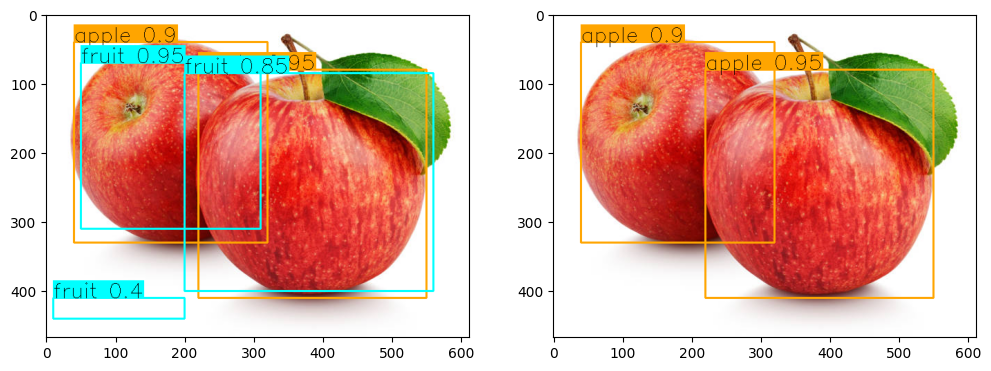

In [126]:
import cv2
import matplotlib.pyplot as plt

# Image name
image_name = 'apples.jpg'

apple_id = 'n07739125'
fruit_id = 'n13134947'

color_map = {
    apple_id: (255, 165, 0),
    fruit_id: (0, 255, 255),
}

# Bounding boxes
boxes = np.asarray([(40, 40, 320, 330), (220, 80, 550, 410), (50, 70, 310, 310), (200, 85, 560, 400), (10, 410, 200, 440)])
scores = np.asarray([0.9, 0.95, 0.95, 0.85, 0.4])
classes = np.asarray([apple_id, apple_id, fruit_id, fruit_id, fruit_id])

# Read image
image = cv2.imread(image_name)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Copy image as original
org = image.copy()

# Draw parameters
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 1
thickness = 1

# threshold
score_threshold = 0.5
iou_threshold = 0.5

# Draw bounding boxes and confidence score
for (start_x, start_y, end_x, end_y), confidence, class_id in zip(boxes, scores, classes):
    color = color_map[class_id]
    class_name = class_hierarchy.convert_id_to_name(class_id)
    text = f'{class_name} {confidence}'
    (w, h), baseline = cv2.getTextSize(text, font, font_scale, thickness)
    cv2.rectangle(org, (start_x, start_y - (2 * baseline + 5)), (start_x + w, start_y), color, -1)
    cv2.rectangle(org, (start_x, start_y), (end_x, end_y), color, 2)
    cv2.putText(org, text, (start_x, start_y), font, font_scale, (0, 0, 0), thickness)

# Run non-max suppression algorithm with hierarchy
nms_idx = non_max_suppression_hierarchy(boxes, scores, classes, class_hierarchy, score_threshold, iou_threshold)
picked_boxes = boxes[nms_idx].astype(int)
picked_scores = scores[nms_idx]
picked_classes = classes[nms_idx]

# # Draw bounding boxes and confidence score after non-maximum supression
for (start_x, start_y, end_x, end_y), confidence, class_id in zip(picked_boxes, picked_scores, picked_classes):
    color = color_map[class_id]
    class_name = class_hierarchy.convert_id_to_name(class_id)
    text = f'{class_name} {confidence}'
    (w, h), baseline = cv2.getTextSize(text, font, font_scale, thickness)
    cv2.rectangle(image, (start_x, start_y - (2 * baseline + 5)), (start_x + w, start_y), color, -1)
    cv2.rectangle(image, (start_x, start_y), (end_x, end_y), color, 2)
    cv2.putText(image, text, (start_x, start_y), font, font_scale, (0, 0, 0), thickness)

# Show image
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(org)

plt.subplot(1, 2, 2)
plt.imshow(image)
plt.show()